In [20]:
# Original Mushrooms dataset https://archive.ics.uci.edu/
!pip install -q ucimlrepo
!pip install -q --no-deps scikeras

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
import datetime
from colorama import Fore, Style
import lightgbm
import xgboost
import catboost
from scikeras.wrappers import KerasClassifier
import keras
from ucimlrepo import fetch_ucirepo 
import scipy.special
from tqdm import tqdm
import warnings
import gc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RepeatedStratifiedKFold, train_test_split, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer, LabelEncoder, OneHotEncoder, PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score, log_loss, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric

import gc

import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [22]:
path_sample_submission_csv = "/kaggle/input/playground-series-s4e8/sample_submission.csv"
path_test_csv = "/kaggle/input/playground-series-s4e8/test.csv"
path_train_csv = "/kaggle/input/playground-series-s4e8/train.csv"

In [23]:
class MushroomData:
    """
    A class for preprocessing mushroom datasets for machine learning.

    The `MushroomData` class provides various methods for loading, cleaning, transforming, scaling, and encoding mushroom
    datasets. It handles both training and test datasets, allowing for efficient data preparation tailored for machine learning tasks.

    Attributes:
        df_train (pd.DataFrame): The training dataset loaded from a CSV file.
        df_test (pd.DataFrame or None): The test dataset loaded from a CSV file, or None if no test data is provided.
        categorical_columns (list or None): List of column names that are categorical. Initialized as None and populated during processing.
        numerical_columns (list or None): List of column names that are numerical. Initialized as None and populated during processing.
        encoder (dict): A dictionary to store encoders for each categorical column.
        categories (dict): A dictionary mapping each categorical feature to its valid categories.
        poly (PolynomialFeatures or None): An instance of PolynomialFeatures from scikit-learn for polynomial feature transformations.
        poly_feature_names (list or None): A list of names for the polynomial features generated.
        scaler (StandardScaler, MinMaxScaler, RobustScaler, or None): A scaler instance from scikit-learn used for numerical data scaling.
        encoders (dict): A dictionary storing fitted encoders for each categorical feature.
    """
    def __init__(self, path_train_csv, path_test_csv = None, nrows = None, load_orginal_dataset = False):
        """
        Initializes the MushroomData object and loads the training dataset.

        Args:
            path_train_csv (str): Path to the CSV file containing the training dataset.
            path_test_csv (str, optional): Path to the CSV file containing the test dataset. Defaults to None.
            nrows (int, optional): Number of rows to read from the CSV files. If None, all rows are read. Defaults to None.
            load_orginal_dataset (bool, optional): If True, loads additional data from the UCI repository. Defaults to False.
        """
            
        self.df_train = pd.read_csv(path_train_csv, index_col = 'id', nrows = nrows)
        if load_orginal_dataset == True:
            df_original = fetch_ucirepo(id=848)['data']['original']
            self.df_train = pd.concat([self.df_train, df_original], axis=0, ignore_index=True)
            
        self.categorical_columns = None
        self.numerical_columns = None
        
        if path_test_csv != None:
            self.df_test = pd.read_csv(path_test_csv, index_col = 'id', nrows = nrows)
        else:
            self.df_test = None

        self.encoder = {}
        
        self.categories = {
            'cap-shape': ['b', 'c', 'x', 'f', 's', 'p', 'o'],
            'cap-surface': ['i', 'g', 'y', 's', 'h', 'l', 'k', 't', 'w', 'e'],
            'cap-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k'],
            'does-bruise-or-bleed': ['t', 'f'],
            'gill-attachment': ['a', 'x', 'd', 'e', 's', 'p', 'f', '?'],
            'gill-spacing': ['c', 'd', 'f'],
            'gill-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
            'stem-root': ['b', 's', 'c', 'u', 'e', 'z', 'r'],
            'stem-surface': ['i', 'g', 'y', 's', 'h', 'l', 'k', 't', 'w', 'e', 'f'],  # Same as cap-surface plus 'f'
            'stem-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
            'veil-type': ['p', 'u'],
            'veil-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
            'has-ring': ['t', 'f'],
            'ring-type': ['c', 'e', 'r', 'g', 'l', 'p', 's', 'z', 'y', 'm', 'f', '?'],
            'spore-print-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k'],  # Same as cap-color
            'habitat': ['g', 'l', 'm', 'p', 'h', 'u', 'w', 'd'],
            'season': ['s', 'u', 'a', 'w']
            }
    
    def load_test(self, path_train_csv, nrows = None):
        """
        Loads the test dataset from a specified CSV file.

        Args:
            path_test_csv (str): Path to the CSV file containing the test dataset.
            nrows (int, optional): Number of rows to read from the CSV file. If None, all rows are read. Defaults to None.
        """
        self.df_test = pd.read_csv(path_test_csv, index_col = 'id', nrows = nrows)
        
    def clean_cats(self, string):
        """
        Cleans a string representing a categorical value.

        Replaces non-string entries or NaN values with 'missing'. For valid strings, extracts single-character codes.

        Args:
            string (str): The string to clean.
        
        Returns:
            str: Cleaned single-character code or 'missing' if not valid.
        """
        if pd.isna(string):
            return 'missing'
        elif type(string)!=str:
            return 'missing'
        ans=None
        words=string.split()
        for word in words:
            word = re.sub(r'[^a-zA-Z?]', '', word)
            if len(word)==1:
                ans=word
        if ans == None or ans=='':
            ans='missing'
        return ans   
        
    def clean_numerical_train(self):
        """
        Cleans numerical features in the training dataset.

        Converts numerical features to numeric types and fills missing values with the mean of the respective column.
        """
        self.numerical_columns = self.df_train.select_dtypes(include=['number']).columns
        for numerical_feature in self.numerical_columns:
            self.df_train[numerical_feature] = pd.to_numeric(self.df_train[numerical_feature]).fillna(self.df_train[numerical_feature].mean())
            
    def clean_numerical_test(self):
        """
        Cleans numerical features in the test dataset.

        Converts numerical features to numeric types and fills missing values with the mean of the respective column from the training dataset.
        """
        for numerical_feature in self.numerical_columns:
            self.df_test[numerical_feature] = pd.to_numeric(self.df_test[numerical_feature]).fillna(self.df_train[numerical_feature].mean())
    
    def fit_polynomial_features(self, degree=3, interaction_only=False, include_bias=False):
        """
        Fits polynomial features to the numerical data in the training dataset.

        Args:
            degree (int, optional): The degree of the polynomial features. Defaults to 3.
            interaction_only (bool, optional): Whether to include only interaction features. Defaults to False.
            include_bias (bool, optional): Whether to include a bias column in the output. Defaults to False.
        """
        # Initialize PolynomialFeatures
        self.poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias)
        # Generate polynomial features for the training set
        self.poly = self.poly.fit(self.df_train[self.numerical_columns])
        self.poly_feature_names = self.poly.get_feature_names_out()
        
    def transfrom_train_polynomial_features(self):
        """
        Transforms the training dataset with polynomial features.

        Applies the polynomial transformation fitted during `fit_polynomial_features` to the training dataset.
        """
        self.df_train[self.poly_feature_names] = self.poly.transform(self.df_train[self.numerical_columns])
        
    def transfrom_test_polynomial_features(self):
        """
        Transforms the test dataset with polynomial features.

        Applies the polynomial transformation fitted during `fit_polynomial_features` to the test dataset.
        """
        self.df_test[self.poly_feature_names] = self.poly.transform(self.df_test[self.numerical_columns])
    
    def clean_categorical_train(self):
        """
        Cleans categorical features in the training dataset.
    
        Ensures all categorical values are within predefined categories and converts them to the 'category' dtype.
        """
        for column in self.df_train.columns:
            if self.df_train[column].dtype==object and column!='class':
                main_cats = self.categories[column]+['missing']
                self.df_train[column] = self.df_train[column].apply(lambda x: self.clean_cats(x))
                self.df_train[column] = self.df_train[column].apply(lambda x: x if x in main_cats else 'noise')
                self.df_train[column] = self.df_train[column].astype('category')
                
    def clean_categorical_test(self):
        """
        Cleans categorical features in the test dataset.

        Ensures all categorical values are within predefined categories and converts them to the 'category' dtype.
        """
        for column in self.df_test.columns:
            if self.df_test[column].dtype==object and column!='class':
                main_cats = self.categories[column]+['missing']
                self.df_test[column] = self.df_test[column].apply(lambda x: self.clean_cats(x))
                self.df_test[column] = self.df_test[column].apply(lambda x: x if x in main_cats else 'noise')
                self.df_test[column] = self.df_test[column].astype('category')

    def clean_train_dataset(self):
        """
        Cleans both numerical and categorical features in the training dataset.

        A wrapper method that applies `clean_numerical_train` and `clean_categorical_train`.
        """
        self.clean_numerical_train()
        self.clean_categorical_train()
        
    def clean_test_dataset(self):
        """
        Cleans both numerical and categorical features in the test dataset.

        A wrapper method that applies `clean_numerical_test` and `clean_categorical_test`.
        """
        self.clean_numerical_test()
        self.clean_categorical_test()
        
    def scaler_fit(self, scaler='StandardScaler', verbose = False):
        """
        Fits a specified scaler to the numerical data in the training dataset.

        Args:
            scaler (str, optional): The type of scaler to use ('StandardScaler', 'MinMaxScaler', or 'RobustScaler'). Defaults to 'StandardScaler'.
            verbose (bool, optional): If True, prints progress information. Defaults to False.
    
        Raises:
            ValueError: If the specified scaler name does not match available options.
        """
        # Initialize the scaler based on the input parameter
        if scaler == 'StandardScaler':
            if verbose:
                print("Fitting StandardScaler")
            self.scaler = StandardScaler()
        elif scaler == 'MinMaxScaler':
            if verbose:
                print("Fitting MinMaxScaler")
            self.scaler = MinMaxScaler()
        elif scaler == 'RobustScaler':
            if verbose:
                print("Fitting RobustScaler")
            self.scaler = RobustScaler()
        else:
            raise ValueError("Scaler name does not match")
        
        # Fit the scaler on the training data
        self.scaler.fit(self.df_train.select_dtypes(include=['number']))
        
    def scaler_train_transform(self, verbose = False):
        """
        Transforms the numerical data in the training dataset using the fitted scaler.

        Args:
            verbose (bool, optional): If True, prints progress information. Defaults to False.
    
        Raises:
            AttributeError: If the scaler has not been fitted before calling this method.
        """
        # Transform both training and test datasets using the fitted scaler
        if not hasattr(self, 'scaler'):
            raise AttributeError("Scaler has not been fitted. Call `scale_fit` first.")
        if verbose:
            print("Transforming df_train with the scaler")
        self.df_train[self.df_train.select_dtypes(include=['number']).columns] =\
        self.scaler.transform(self.df_train.select_dtypes(include=['number']))
        
    def scaler_test_transform(self, verbose = False):
        """
        Transforms the numerical data in the test dataset using the fitted scaler.

        Args:
            verbose (bool, optional): If True, prints progress information. Defaults to False.
    
        Raises:
            AttributeError: If the scaler has not been fitted before calling this method.
        """
        # Transform both training and test datasets using the fitted scaler
        if not hasattr(self, 'scaler'):
            raise AttributeError("Scaler has not been fitted. Call `scale_fit` first.")
        if verbose: 
            print("Transforming df_test with the scaler")
        #self.df_test[self.df_test.select_dtypes(include=['number']).columns] = \
        #self.scaler.transform(self.df_test.select_dtypes(include=['number']))
        self.df_test[self.numerical_columns] = \
        self.scaler.transform(self.df_test[self.numerical_columns])
    
    def encode_categorical_fit(self, encoder='LabelEncoder'):
        """
        Fits encoders for the categorical data in the training dataset.

        Args:
            encoder (str, optional): The type of encoder to use ('LabelEncoder' or 'OneHotEncoder'). Defaults to 'LabelEncoder'.
        """
        self.encoders = {}  # Dictionary to store encoders for each column
    
        self.categorical_columns = [col for col in self.df_train.select_dtypes(include='category').columns if col != 'class']
    
        for column in self.categorical_columns:
            classes = self.categories[column] + ['missing'] + ['noise']
            if encoder == 'LabelEncoder':
                le = LabelEncoder()
                #le.fit(pd.concat([self.df_train[column], self.df_test[column]]))
                le.fit(classes)
                self.encoders[column] = le  # Store the fitted LabelEncoder for this column
            
            elif encoder == 'OneHotEncoder':
                ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
                ohe.fit(self.df_train[[column]])
                self.encoders[column] = ohe  # Store the fitted OneHotEncoder for this column
            
            else:
                print("Encoder name does not match")         
    
    def encode_categorical_transform_train(self):    
        """
        Transforms the categorical data in the training dataset using the fitted encoders.

        This method applies the transformations fitted during `encode_categorical_fit` to the training dataset.
        """
        for column in self.categorical_columns:
        
            if column in self.encoders:
                encoder = self.encoders[column]
            
                if isinstance(encoder, LabelEncoder):
                    self.df_train[column] = encoder.transform(self.df_train[column])
                
                elif isinstance(encoder, OneHotEncoder):
                    # Transform and convert back to DataFrame with appropriate column names
                    encoded_data = encoder.transform(self.df_train[[column]])
                    encoded_df = pd.DataFrame(
                        encoded_data.toarray(),
                        columns=[f"{column}_{cat}" for cat in encoder.categories_[0]],
                        index=self.df_train.index
                    )
                
                    # Drop the original column and concatenate the new one-hot encoded columns
                    self.df_train = self.df_train.drop(column, axis=1)
                    self.df_train = pd.concat([self.df_train, encoded_df], axis=1)
                
            else:
                print(f"No encoder found for column: {column}. Skipping transformation.")

    def encode_categorical_transform_test(self):
        """
        Transforms the categorical data in the test dataset using the fitted encoders.

        This method applies the transformations fitted during `encode_categorical_fit` to the test dataset.
        """
    
        for column in self.categorical_columns:
            if column in self.encoders:
                encoder = self.encoders[column]
            
                if isinstance(encoder, LabelEncoder):
                    self.df_test[column] = encoder.transform(self.df_test[column])
                
                elif isinstance(encoder, OneHotEncoder):
                    # Transform and convert back to DataFrame with appropriate column names
                    encoded_data = encoder.transform(self.df_test[[column]])
                    encoded_df = pd.DataFrame(
                        encoded_data.toarray(),
                        columns=[f"{column}_{cat}" for cat in encoder.categories_[0]],
                        index=self.df_test.index
                    )
                
                    # Drop the original column and concatenate the new one-hot encoded columns
                    self.df_test = self.df_test.drop(column, axis=1)
                    self.df_test = pd.concat([self.df_test, encoded_df], axis=1)
                
            else:
                print(f"No encoder found for column: {column}. Skipping transformation.")
    
    def optimize_dataframe(self, df, verbose = 1):
        """
        Converts columns in numerical_categories to float32 and every other column to binary (int8).
    
        Args:
        - df (pd.DataFrame): The input DataFrame to optimize.

        Returns:
        - pd.DataFrame: Optimized DataFrame with modified data types.
        """
        initial_memory_usage = df.memory_usage(deep=True).sum()/(1024 ** 2)
        
        # Convert specified numerical columns to float32 and bool
        for col in df.columns:
            if col in self.numerical_columns:
                df[col] = df[col].astype('float32')
            elif (col not in self.numerical_columns and col != 'class'):
                df[col] = df[col].astype('int8')
                
                # Convert to megabytes for a more readable format
        final_memory_usage = df.memory_usage(deep=True).sum()/(1024 ** 2)
        reduction_percentage = 100 * (initial_memory_usage - final_memory_usage) / initial_memory_usage
        
        print(f"Initial memory usage: {initial_memory_usage} MB")
        print(f"Final memory usage: {final_memory_usage} MB")
        print(f"Memory reduction percentage: {reduction_percentage:.2f}%")
        
        return df 

    def prepare_train_dataset(self, verbose = False, scaler = 'RobustScaler', encoder = 'OneHotEncoder'):
        """
        Prepares the training dataset by cleaning, scaling, and encoding.

        This method cleans the training dataset, scales numerical features, and encodes categorical features.

        Args:
            verbose (bool, optional): If True, prints progress information. Defaults to False.
            scaler (str, optional): The type of scaler to use for scaling numerical data. Defaults to 'RobustScaler'.
            encoder (str, optional): The type of encoder to use for encoding categorical data. Defaults to 'OneHotEncoder'.
        """
        if verbose:
            print("Starting the preparation of the training dataset...")
        self.clean_train_dataset()
        if verbose:
            print("Training dataset cleaned.")

        self.scaler_fit(scaler, verbose=verbose)
        if verbose:
            print(f"Scaler '{scaler}' fitted to training data.")

        self.scaler_train_transform(verbose=verbose)
        if verbose:
            print("Training dataset scaled.")

        self.encode_categorical_fit(encoder=encoder)
        if verbose:
            print(f"Categorical encoder '{encoder}' fitted to training data.")

        self.encode_categorical_transform_train()
        if verbose:
            print("Training dataset categorical features transformed.")
            
        self.df_train = self.optimize_dataframe(self.df_train, verbose = verbose)
        if verbose:
            print("Training dataset optimized.")
                                                                                                                                                                                                                                                                                                                                                                                        
    def prepare_test_dataset(self, verbose = False):
        """
        Prepares the test dataset by cleaning, scaling, and encoding.

        This method cleans the test dataset, scales numerical features using the scaler fitted on the training data, and encodes categorical features using encoders fitted on the training data.

        Args:
            verbose (bool, optional): If True, prints progress information. Defaults to False.
        """
        if verbose:
            print("Starting the preparation of the test dataset...")
        self.clean_test_dataset()
        if verbose:
            print("Test dataset cleaned.")

        self.scaler_test_transform(verbose=verbose)
        if verbose:
            print("Test dataset scaled using the fitted scaler.")

        self.encode_categorical_transform_test()
        if verbose:
            print("Test dataset categorical features transformed.")
            
        self.df_test = self.optimize_dataframe(self.df_test, verbose = verbose)
        if verbose:
            print("Training dataset optimized.")

    def return_X_Y(self):
        """
        Returns the feature matrix and target vector from the training dataset.

        This method separates the training dataset into the feature matrix `X` and the target vector `Y`. The target vector
        `Y` is derived from the 'class' column, where the classes 'e' (edible) and 'p' (poisonous) are mapped to 0 and 1, respectively.

        Returns:
            tuple: A tuple containing:
                - X (pd.DataFrame): The feature matrix with all columns except 'class'.
                - Y (pd.Series): The target vector with binary values (0 for 'e' and 1 for 'p').
        """
        Y = self.df_train['class'].map({'e': 0, 'p': 1})
        X = self.df_train.drop('class', axis=1)
        return X, Y

In [37]:
class ClearMemoryCallback(Callback):
    """
    A custom Keras callback to clear the TensorFlow session and trigger garbage collection after each epoch.

    This callback helps to manage memory usage during training, especially useful when training models on limited memory resources.

    Methods:
        on_epoch_end(epoch, logs=None): Clears the TensorFlow backend session and collects garbage at the end of each epoch.
    """
    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of every epoch during training.

        This method clears the TensorFlow session and forces garbage collection to free up memory.

        Args:
            epoch (int): The index of the current epoch.
            logs (dict, optional): A dictionary of logs from the training process. Defaults to None.

        Returns:
            None
        """
        K.clear_session()
        gc.collect()
        
        
class MatthewsCorrelationCoefficient(Metric):
    """
    A custom TensorFlow Keras metric to compute the Matthews Correlation Coefficient (MCC).

    The Matthews Correlation Coefficient is a measure of the quality of binary classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure, even if the classes are of very different sizes.

    Attributes:
        true_positives (tf.Variable): A TensorFlow variable to track the count of true positives.
        true_negatives (tf.Variable): A TensorFlow variable to track the count of true negatives.
        false_positives (tf.Variable): A TensorFlow variable to track the count of false positives.
        false_negatives (tf.Variable): A TensorFlow variable to track the count of false negatives.
    
    Methods:
        update_state(y_true, y_pred, sample_weight=None): Updates the state of the metric with new observations.
        result(): Computes and returns the Matthews Correlation Coefficient based on the current state.
        reset_state(): Resets the state of the metric to its initial value.
    """
    def __init__(self, name='matthews_correlation_coefficient', **kwargs):
        """
        Initializes the MatthewsCorrelationCoefficient object.

        Args:
            name (str, optional): The name of the metric. Defaults to 'matthews_correlation_coefficient'.
            **kwargs: Additional keyword arguments for the Metric base class.

        Returns:
            None
        """
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(shape = (),name='true_positives', initializer='zeros')
        self.true_negatives = self.add_variable(shape=(),name='true_negatives', initializer='zeros')
        self.false_positives = self.add_variable(shape=(),name='false_positives', initializer='zeros')
        self.false_negatives = self.add_variable(shape=(),name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the state variables with new observations.

        Args:
            y_true (tf.Tensor): The ground truth values (binary labels).
            y_pred (tf.Tensor): The predicted values (probabilities or binary outputs).
            sample_weight (tf.Tensor, optional): Optional weighting of each example. Defaults to None.

        Returns:
            None
        """
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.squeeze(y_pred)
        y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.bool)
        
        tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True)), self.dtype))
        tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False)), self.dtype))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)), self.dtype))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False)), self.dtype))
            
        self.true_positives.assign(tp)
        self.true_negatives.assign(tn)
        self.false_positives.assign(fp)
        self.false_negatives.assign(fn)

    def result(self):
        """
        Computes the Matthews Correlation Coefficient (MCC) based on the current state.

        Returns:
            tf.Tensor: The computed MCC value.
        """
        numerator = (self.true_positives * self.true_negatives - self.false_positives * self.false_negatives)
        denominator = K.sqrt(
            (self.true_positives + self.false_positives) *
            (self.true_positives + self.false_negatives) *
            (self.true_negatives + self.false_positives) *
            (self.true_negatives + self.false_negatives)
        )
        mcc = tf.math.divide_no_nan(numerator, (denominator + K.epsilon()))
        return mcc

    def reset_state(self):
        """
        Resets all of the metric state variables to their initial zero values.

        This method is called between epochs or steps to reset metric state.

        Returns:
            None
        """
        self.true_positives.assign(0.0)
        self.true_negatives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

class MushroomClassifier:
    """
    A class for building and training various classifiers on mushroom datasets.

    The `MushroomClassifier` class provides methods for training machine learning models, including an XGBoost classifier,
    a stacking model, and a TensorFlow neural network model. It also includes methods for making predictions and generating
    submission files.

    Attributes:
        X (pd.DataFrame): The feature matrix from the dataset.
        Y (pd.Series): The target vector from the dataset.
        submission_file (str or None): Placeholder for submission file name or path. Currently not utilized directly in the class.
        model_xgb (XGBClassifier or None): The XGBoost classifier model.
        base_models (list of tuples or None): List of base models used for stacking.
        meta_model (LogisticRegression or None): Meta-model used in stacking, initialized after training.
        model_tf (Sequential or None): TensorFlow model, initialized after training.
    """
    def __init__(self, X, Y):
        """
        Initializes the MushroomClassifier object with feature matrix and target vector.

        Args:
            X (pd.DataFrame): The feature matrix.
            Y (pd.Series): The target vector.
        """
        self.X = X
        self.Y = Y
        self.submission_file = None
        self.model_xgb = None
        self.base_models = None
        
    def train_xgb_model(self, parameters, verbose = 0, scale_pos = True):
        """
        Trains an XGBoost classifier model on the provided dataset.

        Splits the dataset into training and validation sets, trains the model, and evaluates it using Matthews Correlation Coefficient (MCC) and accuracy.

        Args:
            parameters (dict): Parameters to initialize the XGBoost classifier.
            verbose (int, optional): Verbosity level for training output. Defaults to 0.
            scale_pos (bool, optional): Whether to use scale position weight to handle class imbalance. Defaults to True.
            """
        X_train, X_val, y_train, y_val = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
        
        parameters = parameters
        if scale_pos == True:
            scale_pos_weight = len(Y[Y == 0]) / len(Y[Y == 1])
            parameters['scale_pos_weight'] = scale_pos_weight
        
        self.model_xgb = xgboost.XGBClassifier(**parameters)
        
        self.model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose = verbose)
        y_pred = self.model_xgb.predict(X_val)
        
        mcc = matthews_corrcoef(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)
        if verbose:
            print(f'Matthews Correlation Coefficient on validation set: {mcc}')
            print(f'Accuracy of XGBoost classifier: {accuracy:.5f}')
    
    def train_stack_model(self, parameters, n_splits = 5, verbose = 0, scale_pos = True):
        """
        Trains a stacking classifier model using base models and a meta-model.

        Performs k-fold cross-validation on the training data using various base models and a meta-model for predictions.

        Args:
            parameters (dict): Parameters for initializing base models, specifically the XGBoost model.
            n_splits (int, optional): Number of splits for k-fold cross-validation. Defaults to 5.
            verbose (int, optional): Verbosity level for training output. Defaults to 0.
            scale_pos (bool, optional): Whether to use scale position weight to handle class imbalance. Defaults to True.
        """
        X_train, X_val, y_train, y_val = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
        
        parameters = parameters
        if scale_pos == True:
            scale_pos_weight = len(Y[Y == 0]) / len(Y[Y == 1])
            parameters['scale_pos_weight'] = scale_pos_weight
        
        if self.model_xgb == None:
            self.model_xgb = xgboost.XGBClassifier(**parameters)
            xgb_existed = False
        elif isinstance(self.model_xgb, xgboost.XGBClassifier):
            model_xgb = self.model_xgb
            xgb_existed = True
        
        self.base_models = [
            ('rf', RandomForestClassifier()),
            ('xgb',  model_xgb),
            ("KNN", KNeighborsClassifier()),
            ("Decision Tree", DecisionTreeClassifier()),
            ]

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        oof_preds = np.zeros((X_train.shape[0], len(self.base_models)))
        test_preds = np.zeros((X_val.shape[0], len(self.base_models)))

        for idx, (name, model) in enumerate(self.base_models):
            print(idx)
            oof_preds_model = np.zeros(X_train.shape[0])
            for train_index, valid_index in tqdm(kf.split(X_train), desc=f'Training {name}', total=kf.get_n_splits()):
                X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
                y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

                if name == 'rf':
                    max_samples = 200000
                    if len(X_train_kf) > max_samples:
                        # Randomly sample up to max_samples rows without replacement
                        sampled_indices = np.random.choice(X_train_kf.index, size=max_samples, replace=False)
                        X_train_kf = X_train_kf.loc[sampled_indices]
                        y_train_kf = y_train_kf.loc[sampled_indices]
                elif name == 'SVC':
                    max_samples = 10000
                    if len(X_train_kf) > max_samples:
                        # Randomly sample up to max_samples rows without replacement
                        sampled_indices = np.random.choice(X_train_kf.index, size=max_samples, replace=False)
                        X_train_kf = X_train_kf.loc[sampled_indices]
                        y_train_kf = y_train_kf.loc[sampled_indices]
                elif name == 'KNN':
                    max_samples = 20000
                    if len(X_train_kf) > max_samples:
                        # Randomly sample up to max_samples rows without replacement
                        sampled_indices = np.random.choice(X_train_kf.index, size=max_samples, replace=False)
                        X_train_kf = X_train_kf.loc[sampled_indices]
                        y_train_kf = y_train_kf.loc[sampled_indices]
                elif name == 'Decision Tree':
                    max_samples = 100000
                    if len(X_train_kf) > max_samples:
                        # Randomly sample up to max_samples rows without replacement
                        sampled_indices = np.random.choice(X_train_kf.index, size=max_samples, replace=False)
                        X_train_kf = X_train_kf.loc[sampled_indices]
                        y_train_kf = y_train_kf.loc[sampled_indices]
                
                if name != 'xgb':
                    model.fit(X_train_kf, y_train_kf)
                elif name == 'xgb' and xgb_existed == None:
                    model.fit(X_train_kf, y_train_kf)

            # Predict on validation fold
            oof_preds_model[valid_index] = model.predict(X_valid_kf)
    
            # Store the OOF predictions for this model
            oof_preds[:, idx] = oof_preds_model
    
            # Train on full training data and predict on test data
            test_preds[:, idx] = model.predict_proba(X_val)[:, 1]
    
        # Train the meta-model using OOF predictions
        self.meta_model = LogisticRegression()
        self.meta_model.fit(oof_preds, y_train)

        # Make predictions on the test data
        final_preds = self.meta_model.predict(test_preds)

        mcc = matthews_corrcoef(y_val, final_preds)
        accuracy = accuracy_score(y_val, final_preds)
        if verbose:
            print(f'Accuracy of stack classifier: {accuracy:.5f}')
            print(f'Matthews Correlation Coefficient on validation set: {mcc}')
            
    def train_tf_model(self, fraction_to_use_ = 0.1, batch_size_ = 100*2048, graph_verbose = True):
        """
        Trains a TensorFlow neural network model on a subset of the training dataset.

        Args:
            fraction_to_use_ (float, optional): Fraction of the data to use for training and validation. Defaults to 0.1.
            batch_size_ (int, optional): Batch size for training. Defaults to 128.
            graph_verbose (bool, optional): If True, plots training and validation loss and accuracy graphs. Defaults to True.
           
        """
        # Assuming X_train, y_train, X_val, and y_val are numpy arrays or pandas DataFrames
        X_train, X_val, y_train, y_val = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)

        warnings.filterwarnings('ignore')
        # Convert training and validation data to TensorFlow datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

        # Define the percentage of the data to use (e.g., 1%)
        fraction_to_use = fraction_to_use_

        # Calculate the number of samples to take
        train_sample_count = int(fraction_to_use * len(X_train))
        val_sample_count = int(fraction_to_use * len(X_val))

        # Shuffle and batch the datasets, then take a subset
        train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).take(train_sample_count).batch(batch_size_)
        val_dataset = val_dataset.shuffle(buffer_size=len(X_val)).take(val_sample_count).batch(batch_size_)

        # Define model
        self.model_tf = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(512, activation='linear'),
            BatchNormalization(),
            Dropout(0.2), 
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.2), 
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.2), 
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),  
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),  
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),  
            Dense(16, activation='relu'), 
            BatchNormalization(),
            Dropout(0.05),  
            Dense(8, activation='relu'), 
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ])

        # Compile model
        little_adam = Adam(learning_rate=0.001)
        self.model_tf.compile(loss='binary_crossentropy', optimizer=little_adam, metrics=['accuracy', MatthewsCorrelationCoefficient()])

        # Callbacks for early stopping and learning rate reduction
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)


        history = self.model_tf.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, reduce_lr, ClearMemoryCallback()])

        if graph_verbose:
            # Plot training & validation loss values
            plt.figure(figsize=(20, 8))

            plt.subplot(1, 3, 1)
            plt.plot(history.history['loss'])
        
            plt.plot(history.history['val_loss'])
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend(['Train', 'Validation'])

            # Plot training & validation accuracy values
            plt.subplot(1, 3, 2)
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend(['Train', 'Validation'])
            
            plt.subplot(1, 3, 3)
            plt.plot(history.history['matthews_correlation_coefficient'])
            plt.plot(history.history['val_matthews_correlation_coefficient'])
            plt.title('Model matthews_correlation_coefficient')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend(['Train', 'Validation'])

            plt.show()
    
    def tf_predict(self, df_test):
        """
        Makes predictions on the test dataset using the trained TensorFlow model and generates a submission file.

        This method uses the trained TensorFlow model to predict outcomes for the test dataset. The predictions are thresholded 
        to binary values, mapped to class labels 'e' and 'p', and saved to a CSV submission file.

        Args:
            df_test (pd.DataFrame): The test dataset for which predictions are to be made.

        Returns:
            pd.DataFrame: A DataFrame containing the IDs and predicted class labels for the test dataset.
        """
        # Make predictions using the TensorFlow model
        y_test_pred = self.model_tf.predict(df_test)
    
        # Threshold the predictions to convert them to binary outcomes
        y_test_pred_binary = np.where(y_test_pred >= 0.5, 1, 0)

        # Create a DataFrame for submission
        submission_df = pd.DataFrame({
            'id': df_test.index,
            'class': y_test_pred_binary.flatten()
        })

        # Map the binary predictions to 'e' and 'p'
        submission_df['class'] = np.where(submission_df['class'] == 1, 'p', 'e')
        
        filename = 'submission.csv'
        # Save the submission DataFrame to a CSV file
        submission_df.to_csv(filename, index=False)
        print(f"Submission file created: {filename}")

        return submission_df

    
    def stack_predict(self, df_test):
        """
        Makes predictions on the test dataset using the stacking model and generates a submission file.

        This method utilizes the trained stacking model, combining predictions from multiple base models through a meta-model,
        to predict outcomes for the test dataset. The predictions are mapped to class labels 'e' and 'p' and saved to a CSV 
        submission file.

        Args:
            df_test (pd.DataFrame): The test dataset for which predictions are to be made.

        Returns:
            pd.DataFrame: A DataFrame containing the IDs and predicted class labels for the test dataset.
        """
        test_preds_1 = np.zeros((df_test.shape[0], len(self.base_models)))

        for idx, (name, model) in enumerate(self.base_models):
            test_preds_1[:, idx] = model.predict_proba(df_test)[:, 1]
        # Make predictions on the test data
        final_preds_1 = self.meta_model.predict(test_preds_1)


        submission_df = pd.DataFrame({
            'id': df_test.index,
            'class': final_preds_1
            })
    
        # Map the binary predictions to 'e' and 'p'
        submission_df['class'] = np.where(submission_df['class'] == 1, 'p', 'e')

        # Save the submission DataFrame to a CSV file
        submission_df.to_csv('submission.csv', index=False)
        print("Submission file created: submission.csv")
        return submission_df


    def predict(self, df):
        """
        Makes predictions on the given dataset using the trained XGBoost model and generates a submission file.

        This method uses the trained XGBoost model to predict outcomes for the provided dataset. The predictions are mapped to 
        class labels 'e' and 'p' and saved to a CSV submission file.

        Args:
            df (pd.DataFrame): The dataset for which predictions are to be made.

        Returns:
            pd.DataFrame: A DataFrame containing the IDs and predicted class labels for the dataset.
        """
        y_test_pred = self.model_xgb.predict(df)
        submission_df = pd.DataFrame({
            'id': df.index,
            'class': y_test_pred
            })

        # Map the binary predictions to 'e' and 'p'
        submission_df['class'] = np.where(submission_df['class'] == 1, 'p', 'e')

        # Save the submission DataFrame to a CSV file
        submission_df.to_csv('submission.csv', index=False)
        print("Submission file created: submission.csv")
        return submission_df

In [25]:
md  = MushroomData(path_train_csv, load_orginal_dataset = False, nrows = 2000000)
md.prepare_train_dataset(verbose = True)
X, Y = md.return_X_Y()
md.df_train

Starting the preparation of the training dataset...
Training dataset cleaned.
Fitting RobustScaler
Scaler 'RobustScaler' fitted to training data.
Transforming df_train with the scaler
Training dataset scaled.
Categorical encoder 'OneHotEncoder' fitted to training data.
Training dataset categorical features transformed.
Initial memory usage: 2750.396728515625 MB
Final memory usage: 471.1151123046875 MB
Memory reduction percentage: 82.87%
Training dataset optimized.


,class,cap-diameter,stem-height,stem-width,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_missing,cap-shape_noise,cap-shape_o,...,habitat_m,habitat_missing,habitat_noise,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
id,,,,,,,,,,,,,,,,,,,,,
0,e,0.619919,-0.500000,0.538967,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,p,-0.252033,-0.397810,-0.297653,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,e,0.241870,0.354015,0.026291,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,e,-0.380081,-0.627737,-0.292958,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,e,0.020325,-0.916058,-0.121127,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,e,0.038618,0.014599,0.980282,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1999996,p,-0.530488,0.299270,-0.493897,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1999997,p,-0.065041,-0.116788,0.053521,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [26]:
md.df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 0 to 1999999
Columns: 173 entries, class to season_w
dtypes: float32(3), int8(169), object(1)
memory usage: 375.7+ MB


In [38]:
mc = MushroomClassifier(X, Y)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6722 - loss: 0.6052 - matthews_correlation_coefficient: 0.5566 - val_accuracy: 0.8862 - val_loss: 0.6650 - val_matthews_correlation_coefficient: 0.7792 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9333 - loss: 0.3129 - matthews_correlation_coefficient: 0.8969 - val_accuracy: 0.9366 - val_loss: 0.5929 - val_matthews_correlation_coefficient: 0.8783 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9742 - loss: 0.2097 - matthews_correlation_coefficient: 0.9535 - val_accuracy: 0.9403 - val_loss: 0.4939 - val_matthews_correlation_coefficient: 0.8854 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9821 - loss: 0.1611 - matthews_correlation_coefficient: 0.9667 - val_accuracy: 0.9703 - val_loss: 0.3830 - val_matthews_correlation_coefficient: 0.9407 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/

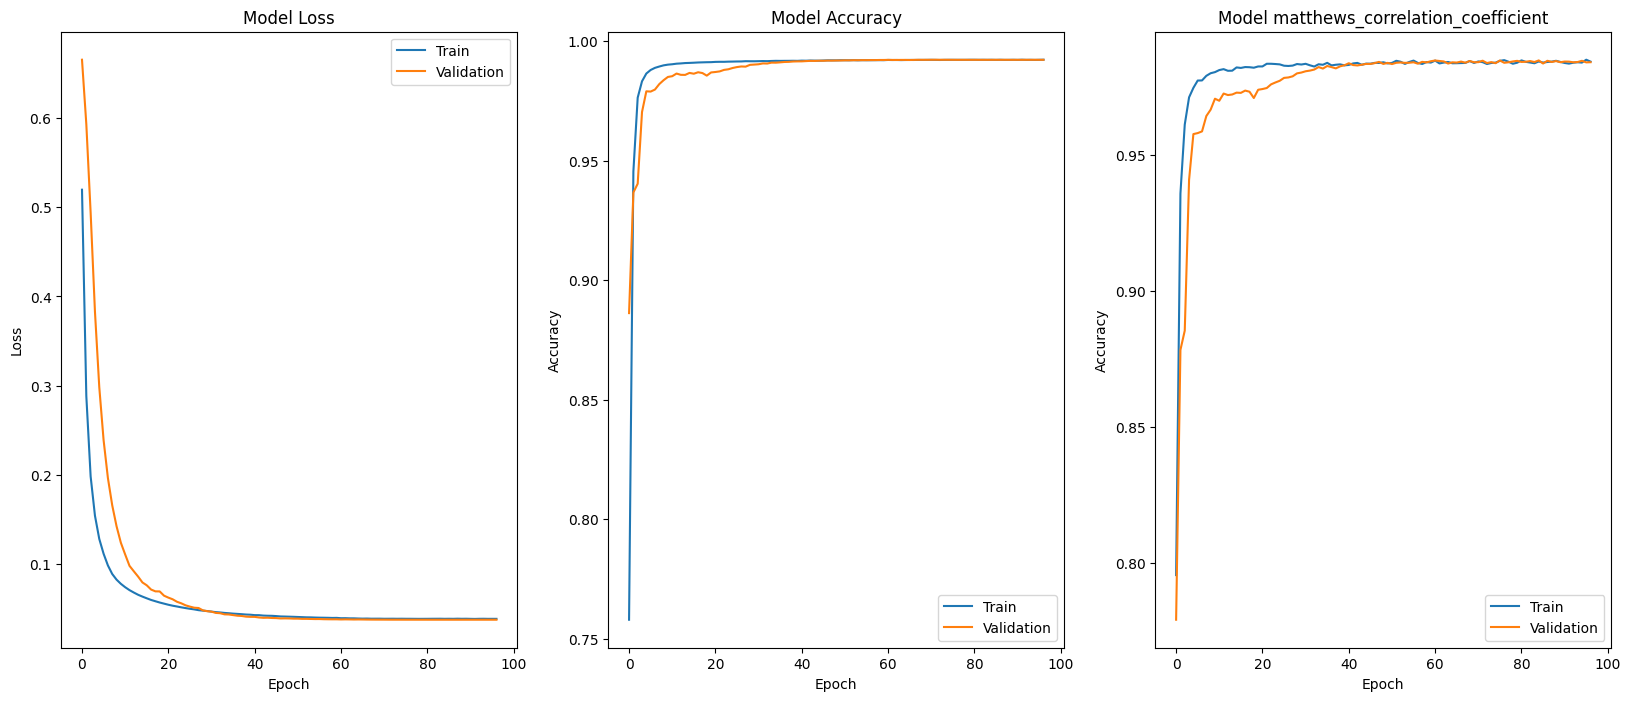

In [39]:
mc.train_tf_model(fraction_to_use_ = 1) #fraction_to_use_ = 0.1)

In [40]:
md.load_test(path_test_csv) #, nrows = 1000)
md.prepare_test_dataset()
md.df_test

Initial memory usage: 2742.674041748047 MB
Final memory usage: 374.5414695739746 MB
Memory reduction percentage: 86.34%


,cap-diameter,stem-height,stem-width,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_missing,cap-shape_noise,cap-shape_o,cap-shape_p,...,habitat_m,habitat_missing,habitat_noise,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
id,,,,,,,,,,,,,,,,,,,,,
3116945,0.587398,1.916058,0.701408,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3116946,0.233740,-1.682482,0.103286,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3116947,-0.762195,0.109489,-0.611268,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3116948,-0.463415,-0.328467,-0.107042,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3116949,0.085366,0.310219,0.380282,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,-0.989837,-1.171533,-0.779343,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5194905,-0.534553,-1.164234,-0.213146,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5194906,-0.004065,0.102190,0.008451,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [41]:
print(mc.tf_predict(md.df_test))

64937/64937 ━━━━━━━━━━━━━━━━━━━━ 104s 2ms/step
Submission file created: submission.csv
              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [43]:
"""parameters = {'n_estimators': 483, 'max_depth': 25, 'learning_rate': 0.018, 'subsample': 0.9947997083813288,
            'colsample_bytree': 0.5336230391923533, 'alpha' : 1 , 'lambda' : 1,
            'gamma': 0.16126940334635828 , 'device': 'cuda'}

mc.train_xgb_model(parameters, verbose = 0, scale_pos = True)
mc.predict(md.df_test)"""

"parameters = {'n_estimators': 483, 'max_depth': 25, 'learning_rate': 0.018, 'subsample': 0.9947997083813288,\n            'colsample_bytree': 0.5336230391923533, 'alpha' : 1 , 'lambda' : 1,\n            'gamma': 0.16126940334635828 , 'device': 'cuda'}\n\nmc.train_xgb_model(parameters, verbose = 0, scale_pos = True)\nmc.predict(md.df_test)"

In [44]:
"""parameters = {'n_estimators': 483, 'max_depth': 25, 'learning_rate': 0.018, 'subsample': 0.9947997083813288,
            'colsample_bytree': 0.5336230391923533, 'alpha' : 1 , 'lambda' : 1,
            'gamma': 0.16126940334635828 , 'device': 'cuda'}

mc.train_stack_model(parameters)
mc.stack_predict(md.df_test)"""

"parameters = {'n_estimators': 483, 'max_depth': 25, 'learning_rate': 0.018, 'subsample': 0.9947997083813288,\n            'colsample_bytree': 0.5336230391923533, 'alpha' : 1 , 'lambda' : 1,\n            'gamma': 0.16126940334635828 , 'device': 'cuda'}\n\nmc.train_stack_model(parameters)\nmc.stack_predict(md.df_test)"